# Representation Similarity Analysis

Reference: 

https://github.com/markallenthornton/MIND18_RSA_tutorial

https://xiaokai.me/post/rsa-tutorial/


In [196]:
import numpy as np 
import pandas as pd 
from scipy.stats import multivariate_normal
from scipy import stats

# regression 
from sklearn.linear_model import LinearRegression

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

from utils.viz import viz 
viz.get_style()

## Abstract 

## Similarity metrics

The concepts of similarity and distance are two sides of a coin, both characterizing the consistency (or inconsistency) between two measurements. There are a few quantitative metrics commonly used in statistical analysis. 

The introduction starts with applying these common metrics on a simulated data set.

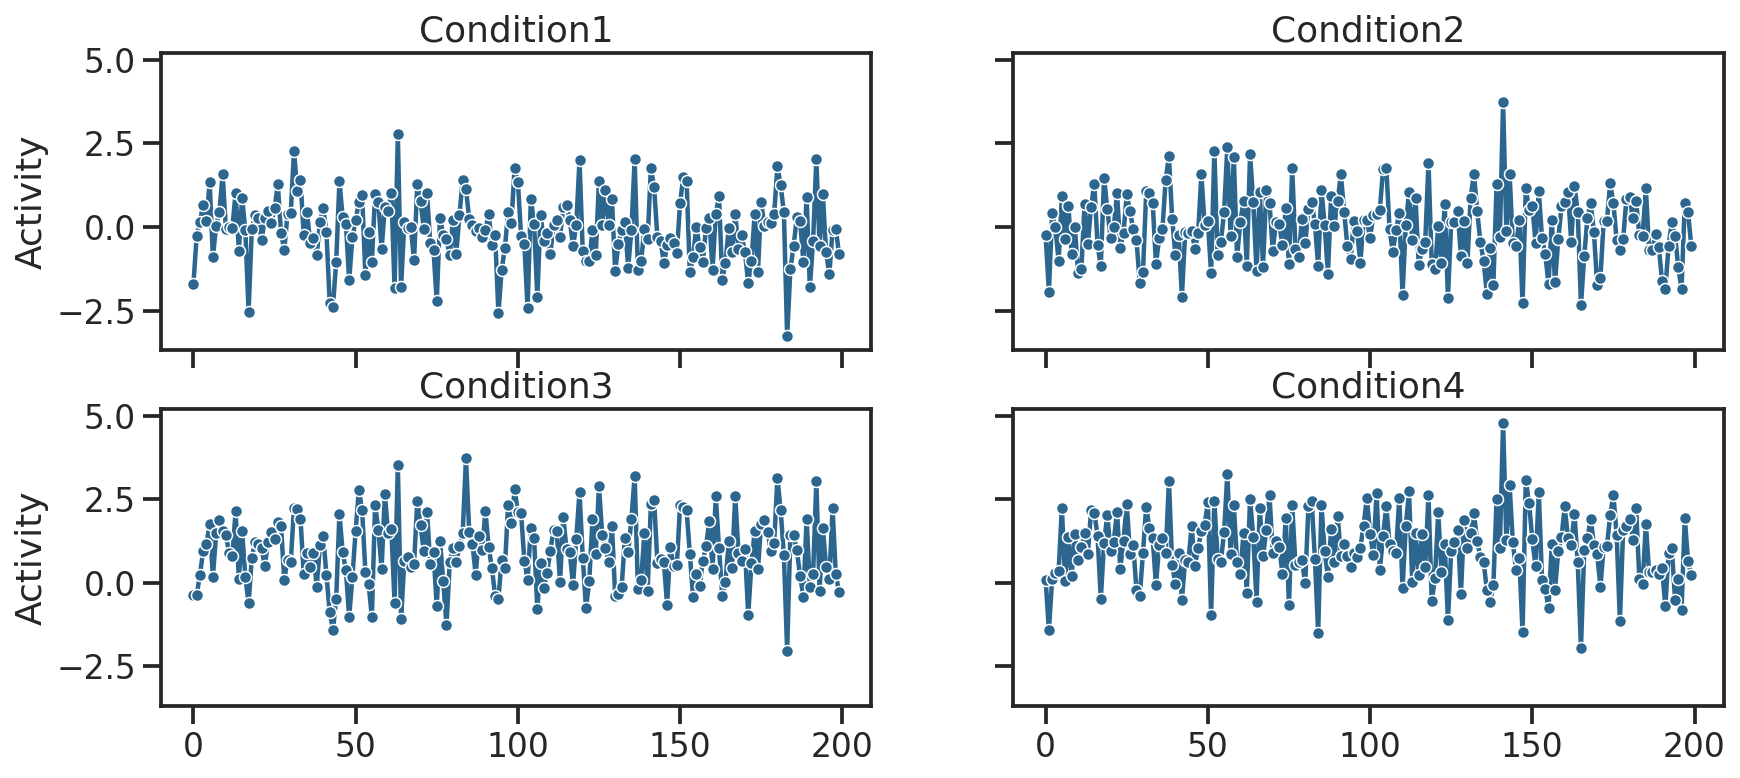

In [98]:
# generate a pseudo data set
rng = np.random.RandomState(1)
sig = np.array([1, 0,.8, 0, 
                0, 1, 0,.8,
               .8, 0, 1, 0, 
                0,.8, 0, 1]).reshape([4, 4])
data = multivariate_normal(mean=[0, 0, 1, 1], cov=sig).rvs(200, random_state=rng)

# viz the data 
nr, nc = 2, 2
fig, axs = plt.subplots(nr, nc, sharex=True, sharey=True,
                            figsize=(nr*7, nc*3))
for i in range(data.shape[1]):
    ax = axs[i//nc, i%nc]
    sns.lineplot(x=np.arange(200), y=data[:, i], marker='o',
                    markersize=6, color=viz.Blue, ax=ax)
    ax.set_ylabel('Activity')
    ax.set_title(f'Condition{i+1}')

### Mean distance

As the name suggests, the mean distance treats the mean of the measurement as the feature of each condition. So the distance between conditions is,

$$d(i,j) = \left(\frac{1}{D}\sum_{k=1}^K(x^i_d) - \frac{1}{D}\sum_{k=1}^K(x^j_d)\right)^2$$

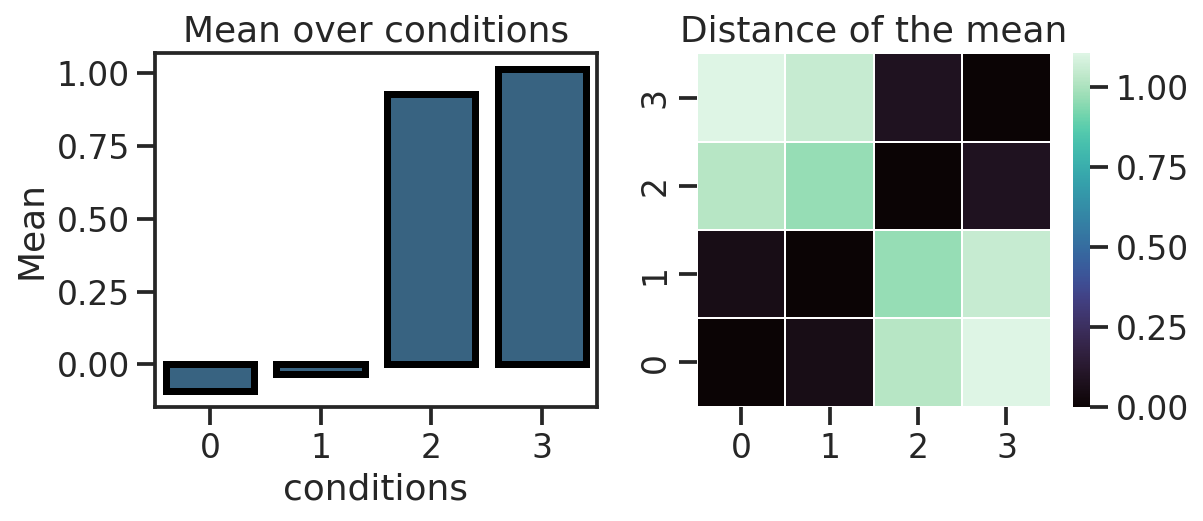

In [99]:
# get mean and distance
dmean = data.mean(0)
Dist_dmean = np.zeros([len(dmean), len(dmean)]) + np.nan
for i, m in enumerate(dmean):
    Dist_dmean[i, :] = np.sqrt((dmean - m)**2)

# viz 
nr, nc = 1, 2
fig, axs = plt.subplots(nr, nc, figsize=(nc*4.3, nr*4))
ax = axs[0]
sns.barplot(x=np.arange(4), y=dmean, lw=3.5,
            edgecolor='k', color=viz.Blue, ax=ax)
ax.set_ylabel('Mean')
ax.set_xlabel('conditions')
ax.set_title('Mean over conditions')

ax = axs[1]
sns.heatmap(data=Dist_dmean, ax=ax, lw=1, cmap='mako')
ax.invert_yaxis()
ax.set_title('Distance of the mean')


fig.tight_layout()

From the bar plot we know that the mean between pairs (0, 1) and pairs (2, 3) are close to each other. These observations are reflected on the metric distance of the mean.

### Euclidean distance

Here, we consider each data point as a feature of a condition. Thus, the euclidean distance between conditions is defined as:

$$d(i,j) = \frac{1}{K}\sum_{k=1}^K(x^i_k - x^j_k)^2$$

Text(0.5, 1.0, 'Euclidean Distance')

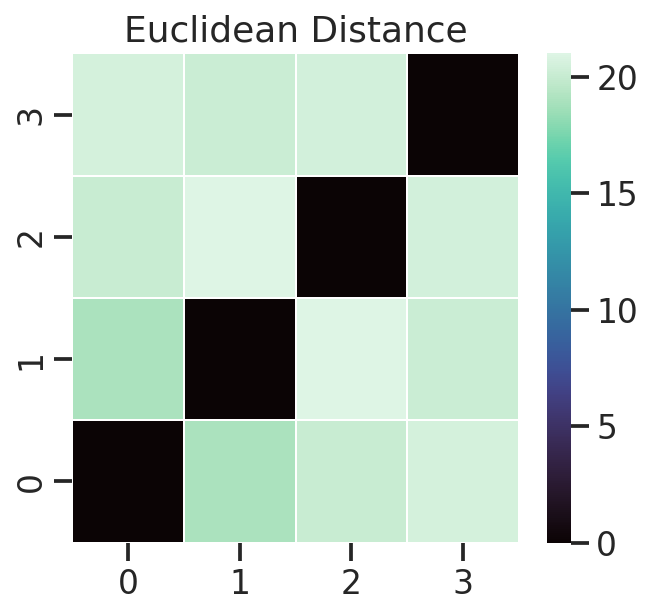

In [100]:
# transpose the data using measurement as features
data = data.reshape([4, -1])
Dist_l2 = [np.sqrt(((data-data[i, :])**2).sum(1)) for i in range(data.shape[0])]

plt.figure(figsize=(5, 4.5))
ax = sns.heatmap(data=Dist_l2, lw=1, cmap='mako')
ax.invert_yaxis()
plt.title('Euclidean Distance')

### Correlation distance 

Correlation distance only use the information in covariance matrix.

$$d(i,j) = 1-Cov(i,j)$$

Text(0.5, 1.0, 'Correlation Distance')

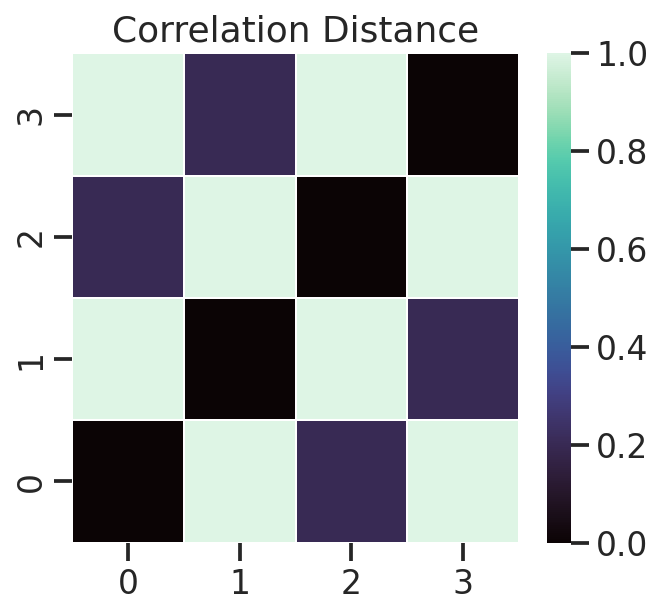

In [101]:
Dist_corr = 1 - sig 

plt.figure(figsize=(5, 4.5))
ax = sns.heatmap(data=Dist_corr, lw=1, cmap='mako')
ax.invert_yaxis()
plt.title('Correlation Distance')

## RSA tutorial: NHST, effect size, cross-validation, and model selection

### Loading data 

The data includes a pair comparision for all possible pairs in 60 famous people. In total, the data includes $C^{60}_2\frac{60!}{2!\times58!} = 1770$ pairs as conditions.

In [157]:
## Load the neural data 
fname = f"data/neural_pattern_similarity.csv"
neural_data = pd.read_csv(fname)
neural_sim = neural_data.mean(1)

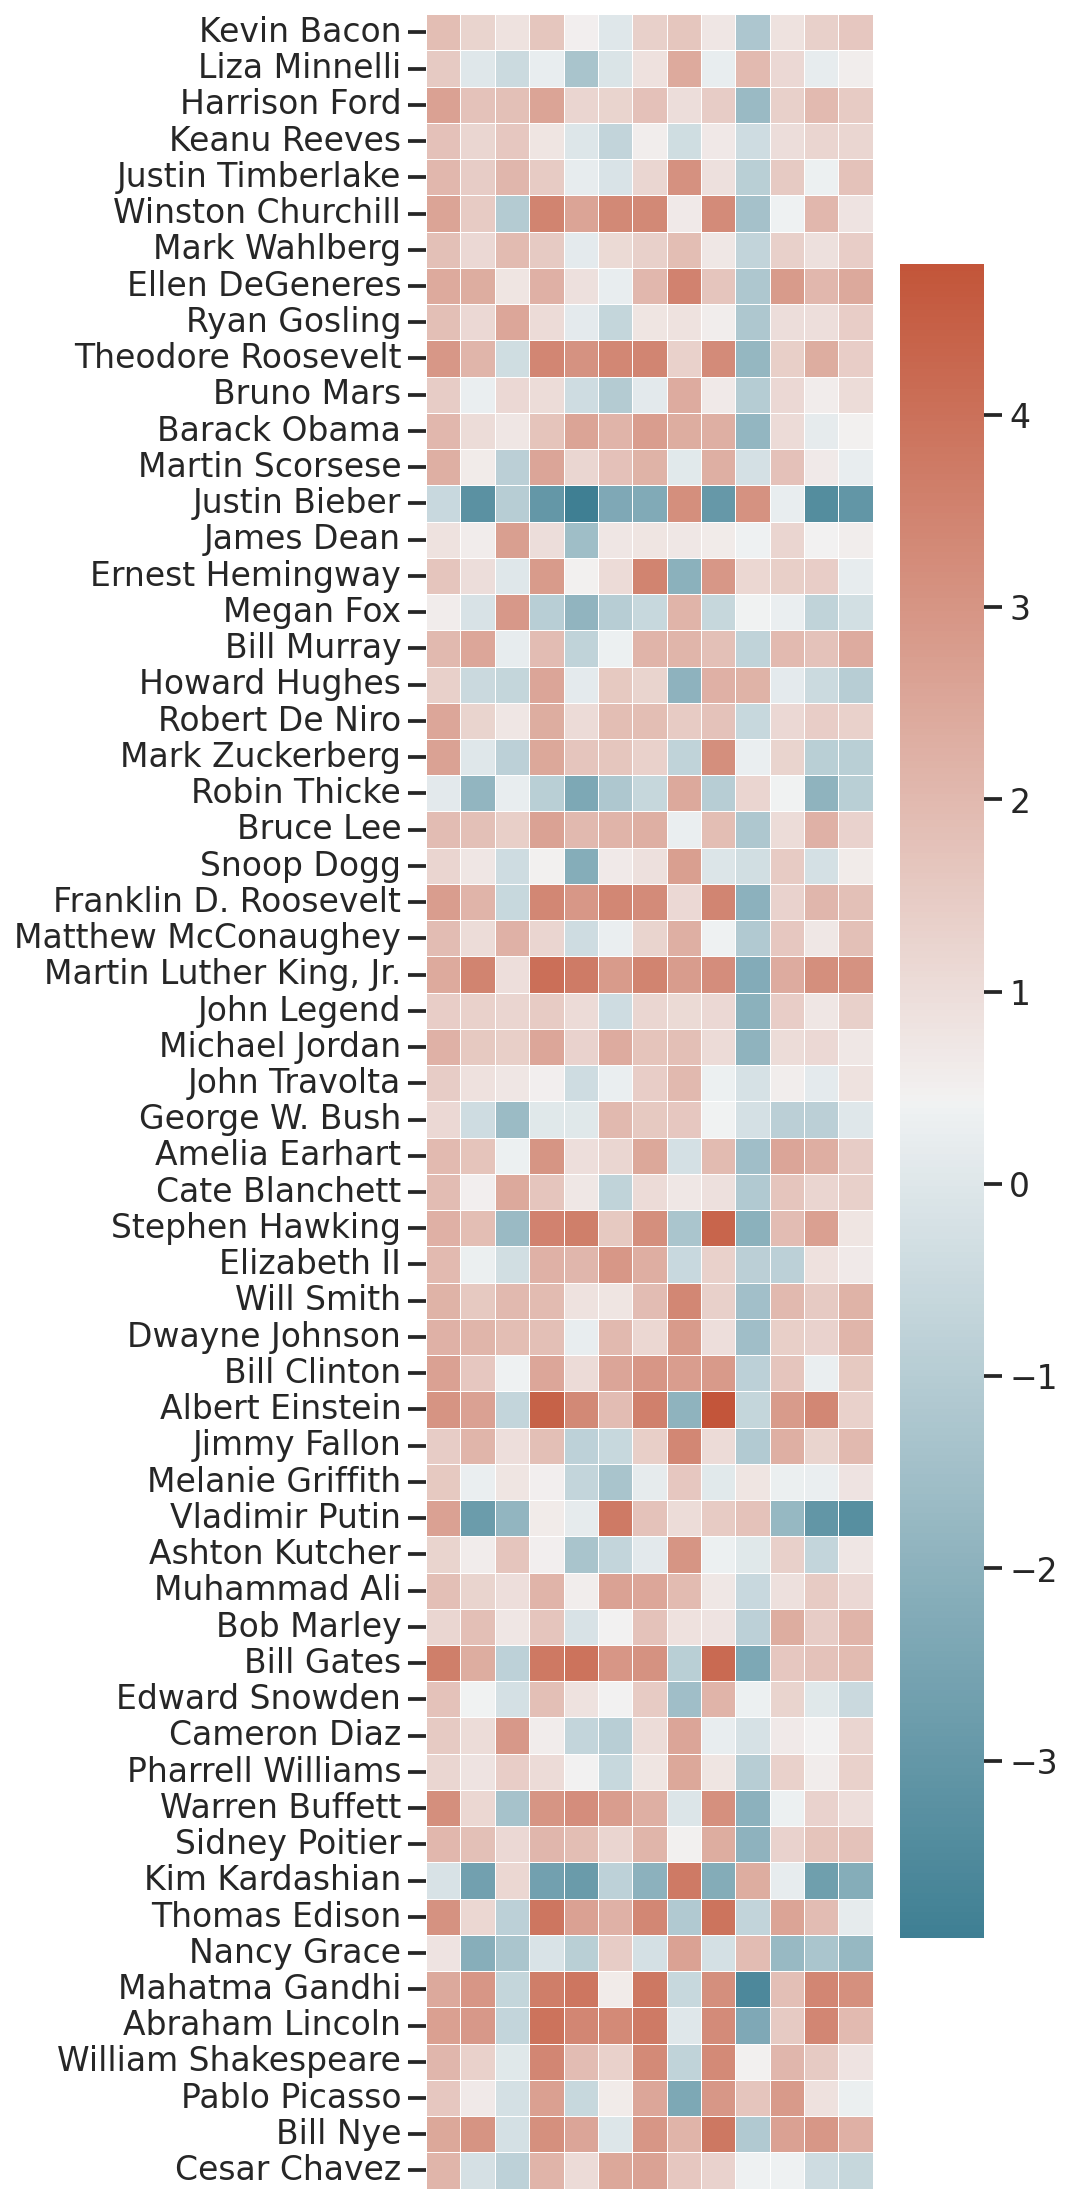

In [158]:
## Trait data 
fname = f'data/dimensions.csv'
trait_data = pd.read_csv(fname)
# rescale
trait_data.iloc[:, 1:14] = (trait_data.iloc[:, 1:14] / (100/10)) - 5

plt.figure(figsize=(5, 20))
ax = sns.heatmap(data=trait_data.iloc[:, 1:14], lw=.5, cmap=sns.diverging_palette(220, 20, as_cmap=True),
                yticklabels=list(trait_data['name'].values), xticklabels=[])
ax.invert_yaxis()

In [163]:
## holistic data 
hol_data = pd.read_csv('data/holdists.csv')
hol_data['holistic'] = hol_data['holistic'].apply(lambda x: 100 - x) 
hol_data['text'] = hol_data['text'].apply(lambda x: 2 - x) 

### Our first RSA

<AxesSubplot:xlabel='Holistic', ylabel='Neural'>

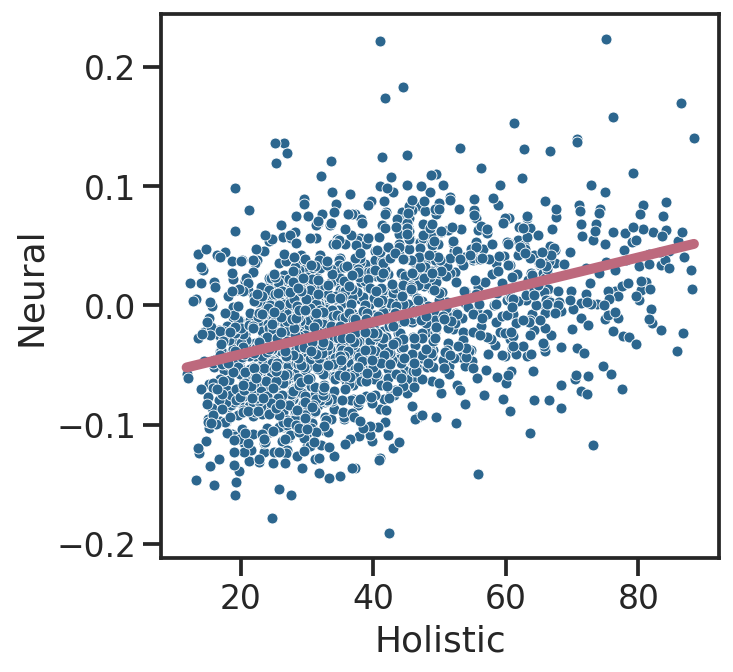

In [192]:
# concate the data 
smary = np.vstack([hol_data['holistic'].values, hol_data['text'].values, neural_sim])
smary = pd.DataFrame(smary.T, columns=['Holistic', 'Text', 'Neural'])

# a correlation between people's holistic and neural data 
def corr(x, y):
    x2sum = ((x - x.mean())**2).sum()
    y2sum = ((y - y.mean())**2).sum()
    cov   = (x - x.mean())*(y - y.mean())
    return (cov / np.sqrt(x2sum*y2sum)).sum()
r = corr(smary['Holistic'], smary['Neural'])

# regression over y, x 
smary['Neural_Hat'] = LinearRegression().fit(
    smary['Holistic'].values.reshape([-1, 1]), smary['Neural'].values).predict(
        smary['Holistic'].values.reshape([-1, 1]))

# viz 
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Holistic', y='Neural', data=smary,
                color=viz.Blue, s=30)
sns.lineplot(x='Holistic', y='Neural_Hat', data=smary,
                color=viz.Red, lw=5)

This is the basic concept of RSA, although neural data and holistic data is not directly comparable, we can calculate their distance in a high dimensional space. So far everything is quite straight forward. 

Quesiton: will standarization help? 

### Null hypothesis sifnificance testing

Is this correlation significant? We conduct a significant test using student-t distribution.

In [211]:
def corr_test(x, y):
    n = len(x)
    r = corr(x, y)
    t = r * np.sqrt((n - 2) / (1-r**2))
    p = stats.t(n-2).sf(t)
    print(f't={t}, df={n-2}, p={p}')

In [212]:
corr_test(smary['Holistic'], smary['Neural'])

t=18.297717385533797, df=1768, p=6.231015122400782e-69


200 samples? It is a really small data sets. Our estimation of correlation may be biased. We can add some variation to the data sets to produce a more robust estimation. The simplest method we can use is bootstrapping. 

In [213]:
from scipy.spatial.distance import squareform

In [215]:
data = squareform(neural_sim)

(60, 60)

In [222]:
cols=9
rng.choice(range(cols), 7)

array([3, 8, 0, 5, 3, 4, 4])

In [ ]:
def bootstrapping(x, y, n_samples=5000, seed=1):
    sq_X = squareform(x)
    rng  = np.random.seed(seed)
    cols = sq_X.shape[0]
    rs   = np.empty([n_samples]) + np.nan
    for i in range(n_samples):  
        sim_ind = rng.choice(cols, cols)
        sim_X = sq_X[sim_ind, sim_ind]
        rs[i] = corr(sim_X, y)